In [1]:
import torch
import torchvision
from torchvision.models import resnet50 as ResNet50
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(pretrained=True).to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
print (model.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [4]:
features_map = []

def get_features_map(module, inputs, output):
    features_map.append(output)

model.layer4.register_forward_hook(get_features_map)


In [5]:
# https://github.com/pytorch/examples/blob/27e2a46c1d1505324032b1d94fc6ce24d5b67e97/imagenet/main.py

In [6]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
        ])

In [7]:
def preprocess(img_path) :
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = transform(img)
    return img

In [8]:
import requests
import json

ImageNet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = requests.get(ImageNet_labels_url)
labels = labels.json()

In [9]:
input = "/content/images.jpg"

In [10]:
with torch.no_grad():
    output = model(preprocess(input).unsqueeze(0).to(device))
    predicted_class = output.argmax(dim=1).item()

In [11]:
predicted_label = labels[predicted_class]
print(f"Predicted class: {predicted_label}")

Predicted class: tabby cat


In [12]:
feature_maps = features_map[0]

In [13]:
type(model.fc.weight)

torch.nn.parameter.Parameter

In [14]:
type(model.fc.weight.data)

torch.Tensor

In [15]:
weights = model.fc.weight.data
weights.shape

torch.Size([1000, 2048])

In [16]:
weighted_feature_map = torch.zeros(feature_maps.size(2), feature_maps.size(3), device=device)

In [18]:
for i in range(weights.size(1)):
    weighted_feature_map += weights[predicted_class, i] * torch.relu(feature_maps[0, i])

In [ ]:
#https://alexisbcook.github.io/posts/global-average-pooling-layers-for-object-localization/

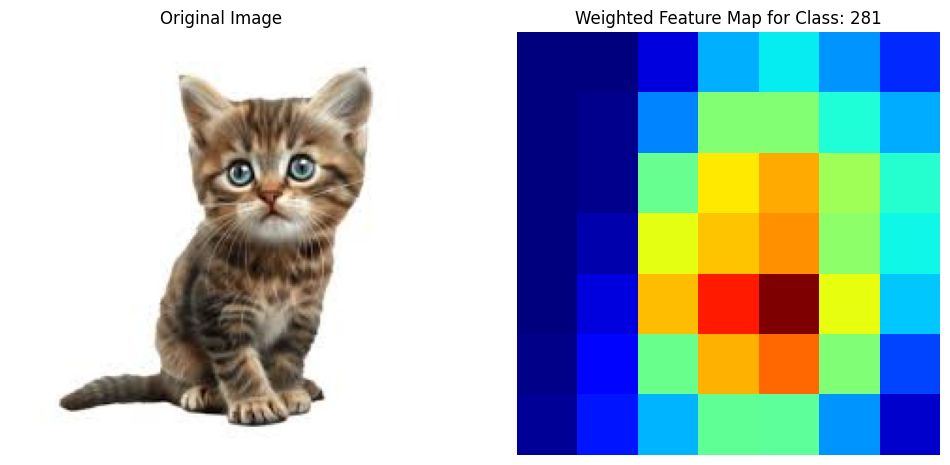

In [20]:
weighted_feature_map -= weighted_feature_map.min()
weighted_feature_map /= weighted_feature_map.max()

heatmap = weighted_feature_map.cpu().numpy()
heatmap = np.uint8(255 * heatmap)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

original_image = Image.open(input)
ax[0].imshow(original_image)
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(heatmap, cmap='jet')
ax[1].axis('off')
ax[1].set_title(f'Weighted Feature Map for Class: {predicted_class}')

plt.show()
